### Overview

- This VaR model is fairly dynamic and allows for adaptability to different lookback periods, new portfolios, different stocks, and multiple VaR assumptions

- The model is robust as it only requires minor data cleaning and compatibility between the dictionary of holdings and the data frame of stock returns

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import chisquare, norm, shapiro

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)  
pd.set_option('display.max_colwidth', None)

In [68]:
# Downloading Stock Data

tickers = ['AMAT', 'GOOGL', 'FTNT', 'RTX']
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)
yf_px_df = yf.download(tickers=tickers, start=start_date, end=end_date)
yf_px_df = yf_px_df['Adj Close']
yf_px_df.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AMAT,FTNT,GOOGL,RTX
Date,,,,
2019-12-31,58.390938,21.351999,66.727600,83.660927
2020-01-02,59.500591,21.936001,68.186821,85.549118
2020-01-03,58.553555,22.242001,67.830109,85.666420
2020-01-06,57.290840,22.400000,69.638054,85.850761
2020-01-07,58.945766,22.378000,69.503548,85.577057


In [69]:
yf_px_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-12-31 to 2024-12-30
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AMAT    1258 non-null   float64
 1   FTNT    1258 non-null   float64
 2   GOOGL   1258 non-null   float64
 3   RTX     1258 non-null   float64
dtypes: float64(4)
memory usage: 49.1 KB


In [70]:
# Creating a Dictionary of the Portfolio's Holdings

hlds_dict = {'AMAT': 75,
             'GOOGL': 100,
             'FTNT': 75,
             'RTX': 150}

In [71]:
# Creating a Comprehensive VaR Class

class ValueAtRisk:
    

    def __init__(self, px_hist, hlds, percentile, alpha, lookback, bins):
        self.px_hist = px_hist
        self.hlds = hlds
        self.percentile = percentile
        self.alpha = alpha
        self.lookback = lookback
        self.bins = bins


    # Portfolio's Daily Returns
    def portfolio_returns(self):

        relevant_px_hist = self.px_hist[self.hlds.keys()].copy()

        for col in relevant_px_hist.columns:
            if col in list(self.hlds.keys()):
                relevant_px_hist.loc[:, col] = self.hlds[col] * relevant_px_hist[col]
            else:
                continue

        relevant_px_hist['Portfolio Value'] = relevant_px_hist.sum(axis=1)
        relevant_px_hist['Portfolio Pct Chg'] = relevant_px_hist['Portfolio Value'].pct_change()

        return relevant_px_hist
    

    # Test for Normality
    def shapiro_wilks(self, relevant_px_hist):
        relevant_px_hist = relevant_px_hist.dropna()
        lookback_relevant_px_hist = relevant_px_hist.tail(self.lookback)
        pf_returns = lookback_relevant_px_hist['Portfolio Pct Chg']
        results = shapiro(pf_returns)
        
        return f"Test for normality p-value of {round(results.pvalue, 4)} for {self.lookback} day lookback"
    
    
    # Test for Goodness of Fit
    def chi_square_test(self, relevant_px_hist):
        relevant_px_hist = relevant_px_hist.dropna()
        lookback_relevant_px_hist = relevant_px_hist.tail(self.lookback)
        
        binned = pd.cut(lookback_relevant_px_hist['Portfolio Pct Chg'], bins=self.bins)
        observed_counts = binned.value_counts().sort_index()

        mu = lookback_relevant_px_hist['Portfolio Pct Chg'].mean()
        sigma = lookback_relevant_px_hist['Portfolio Pct Chg'].std()

        bin_edges = binned.cat.categories

        expected_counts = np.zeros(self.bins)
        
        for i, bin_edge in enumerate(bin_edges):
            lower_cdf = norm.cdf(bin_edge.left, mu, sigma)
            upper_cdf = norm.cdf(bin_edge.right, mu, sigma)
            
            bin_probability = upper_cdf - lower_cdf
            
            expected_counts[i] = bin_probability * len(lookback_relevant_px_hist)

        if np.sum(observed_counts) != np.sum(expected_counts):
            expected_counts = expected_counts * (np.sum(observed_counts) / np.sum(expected_counts))

        chi_square_stat, p_value = chisquare(observed_counts, expected_counts)

        return f"Goodness of fit p-value of {round(p_value, 4)} for {self.lookback} day lookback"


    # Histogram of the Portfolio's Returns
    def histogram(self, relevant_px_hist):

        relevant_px_hist = relevant_px_hist.dropna()
        lookback_relevant_px_hist = relevant_px_hist.dropna().tail(self.lookback)
        
        sns.set_style("whitegrid")
        plt.figure(figsize=(10, 6))
        sns.histplot(lookback_relevant_px_hist['Portfolio Pct Chg'], bins=self.bins, edgecolor='black')

        plt.title(f"Distribution of Portfolio Daily Returns | Lookback: {self.lookback}", fontsize=20, fontweight='bold', color='black')
        plt.ylabel("Frequency", fontsize=12, fontweight='bold')
        plt.xlabel("Portfolio Pct Chg", fontsize=12, fontweight='bold')
        plt.xticks(fontsize=10, fontweight='bold')
        plt.yticks(fontsize=10, fontweight='bold')

        sns.despine()
        plt.tight_layout()


    # Normal Portfolio VaR
    def parametric_normal(self, relevant_px_hist):
        lookback_relevant_px_hist = relevant_px_hist.dropna().tail(self.lookback)
        pf_value = relevant_px_hist['Portfolio Value'].iloc[-1]
        pf_returns = lookback_relevant_px_hist['Portfolio Pct Chg']
        
        mu = pf_returns.mean()
        sigma = pf_returns.std()
        z_score = norm.ppf(self.alpha)
        percent_VaR = mu + z_score * sigma

        return f"{round(pf_value*percent_VaR, 2)} VaR for {self.lookback} day lookback"

    
    # Percentile Portfolio VaR
    def historic_percentile(self, relevant_px_hist):

        lookback_relevant_px_hist = relevant_px_hist.dropna().tail(self.lookback)
        pf_value = relevant_px_hist['Portfolio Value'].iloc[-1] 
        percent_VaR = np.percentile(lookback_relevant_px_hist['Portfolio Pct Chg'], self.percentile)
        
        return f"{round(pf_value*percent_VaR, 2)} VaR for {self.lookback} day lookback"

### Value at Risk for 250 Day Lookback Period

In [91]:
# Initializing the ValueAtRisk Class

VaR = ValueAtRisk(px_hist=yf_px_df, hlds=hlds_dict, percentile=5, alpha=0.05, lookback=250, bins=20)

VaR_portfolio_returns = VaR.portfolio_returns()
pd.DataFrame(VaR_portfolio_returns).tail()

Ticker,AMAT,GOOGL,FTNT,RTX,Portfolio Value,Portfolio Pct Chg
Date,,,,,,
2024-12-23,12559.500504,19463.000488,7231.499863,17494.499588,56748.500443,0.010272
2024-12-24,12627.749634,19611.000061,7335.749817,17524.500275,57098.999786,0.006176
2024-12-26,12566.250229,19560.000610,7296.750069,17556.000137,56979.001045,-0.002102
2024-12-27,12512.250137,19275.999451,7206.000137,17506.499863,56500.749588,-0.008393
2024-12-30,12272.999954,19124.000549,7134.749794,17283.000183,55814.750481,-0.012141


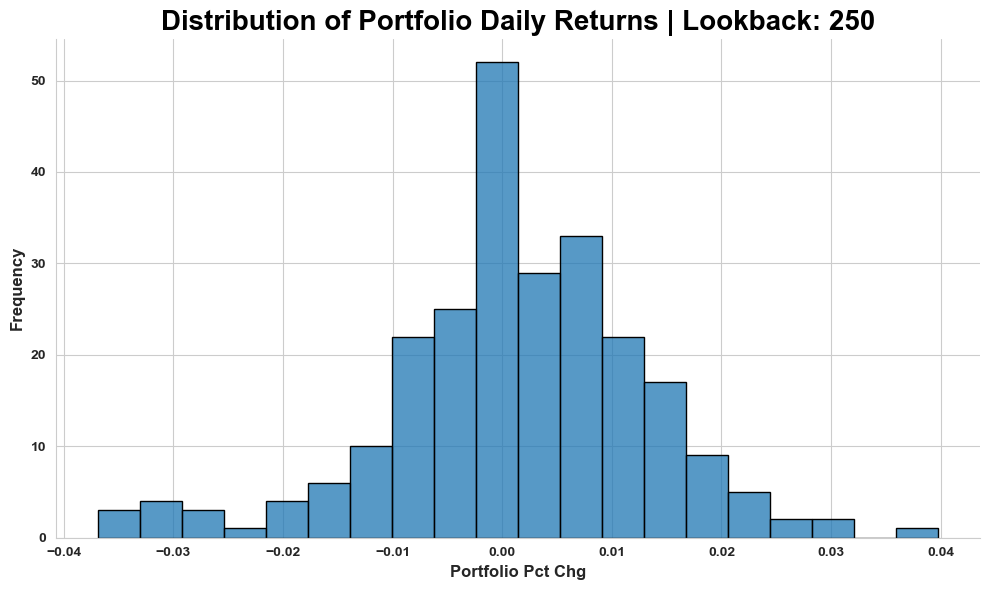

In [73]:
# Visualizing the Portfolio's Return Distribution

VaR.histogram(VaR_portfolio_returns)

In [74]:
# Calculating the Test for Normality

VaR.shapiro_wilks(VaR_portfolio_returns)

'Test for normality p-value of 0.0001 for 250 day lookback'

In [75]:
# Calculating the Chi-Square Test for Goodness of Fit

VaR.chi_square_test(VaR_portfolio_returns)

'Goodness of fit p-value of 0.0 for 250 day lookback'

In [76]:
# Calculating the Portfolio's VaR Using a Parametric Method

VaR.parametric_normal(VaR_portfolio_returns)

'-1019.54 VaR for 250 day lookback'

In [77]:
# Calculating the Portfolio's VaR Using a Historical Percentile Method

VaR.historic_percentile(VaR_portfolio_returns)

'-1063.55 VaR for 250 day lookback'

### Value at Risk for 180 Day Lookback Period

In [78]:
# Initializing the ValueAtRisk Class

VaR = ValueAtRisk(px_hist=yf_px_df, hlds=hlds_dict, percentile=5, alpha=0.05, lookback=180, bins=20)

VaR_portfolio_returns = VaR.portfolio_returns()
pd.DataFrame(VaR_portfolio_returns).head()

Ticker,AMAT,GOOGL,FTNT,RTX,Portfolio Value,Portfolio Pct Chg
Date,,,,,,
2019-12-31,4379.320335,6672.760010,1601.399946,12549.139023,25202.619314,NaN
2020-01-02,4462.544346,6818.682098,1645.200062,12832.367706,25758.794212,0.022068
2020-01-03,4391.516590,6783.010864,1668.150043,12849.962997,25692.640495,-0.002568
2020-01-06,4296.813011,6963.805389,1679.999971,12877.614212,25818.232584,0.004888
2020-01-07,4420.932484,6950.354767,1678.350019,12836.558533,25886.195803,0.002632


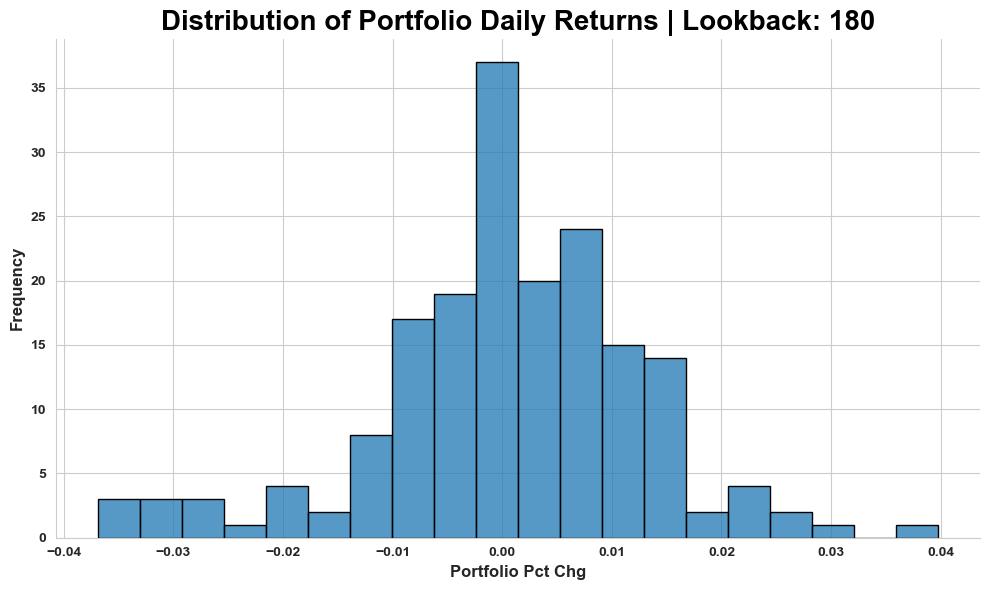

In [79]:
# Visualizing the Portfolio's Return Distribution

VaR.histogram(VaR_portfolio_returns)

In [80]:
# Calculating the Test for Normality

VaR.shapiro_wilks(VaR_portfolio_returns)

'Test for normality p-value of 0.0002 for 180 day lookback'

In [81]:
# Calculating the Chi-Square Test for Goodness of Fit

VaR.chi_square_test(VaR_portfolio_returns)

'Goodness of fit p-value of 0.0 for 180 day lookback'

In [82]:
# Calculating the Portfolio's VaR Using a Parametric Method

VaR.parametric_normal(VaR_portfolio_returns)

'-1089.86 VaR for 180 day lookback'

In [83]:
# Calculating the Portfolio's VaR Using a Historical Percentile Method

VaR.historic_percentile(VaR_portfolio_returns)

'-1346.92 VaR for 180 day lookback'

### Value at Risk for 60 Day Lookback Period

In [84]:
# Initializing the ValueAtRisk Class

VaR = ValueAtRisk(px_hist=yf_px_df, hlds=hlds_dict, percentile=5, alpha=0.05, lookback=60, bins=20)

VaR_portfolio_returns = VaR.portfolio_returns()
pd.DataFrame(VaR_portfolio_returns).head()

Ticker,AMAT,GOOGL,FTNT,RTX,Portfolio Value,Portfolio Pct Chg
Date,,,,,,
2019-12-31,4379.320335,6672.760010,1601.399946,12549.139023,25202.619314,NaN
2020-01-02,4462.544346,6818.682098,1645.200062,12832.367706,25758.794212,0.022068
2020-01-03,4391.516590,6783.010864,1668.150043,12849.962997,25692.640495,-0.002568
2020-01-06,4296.813011,6963.805389,1679.999971,12877.614212,25818.232584,0.004888
2020-01-07,4420.932484,6950.354767,1678.350019,12836.558533,25886.195803,0.002632


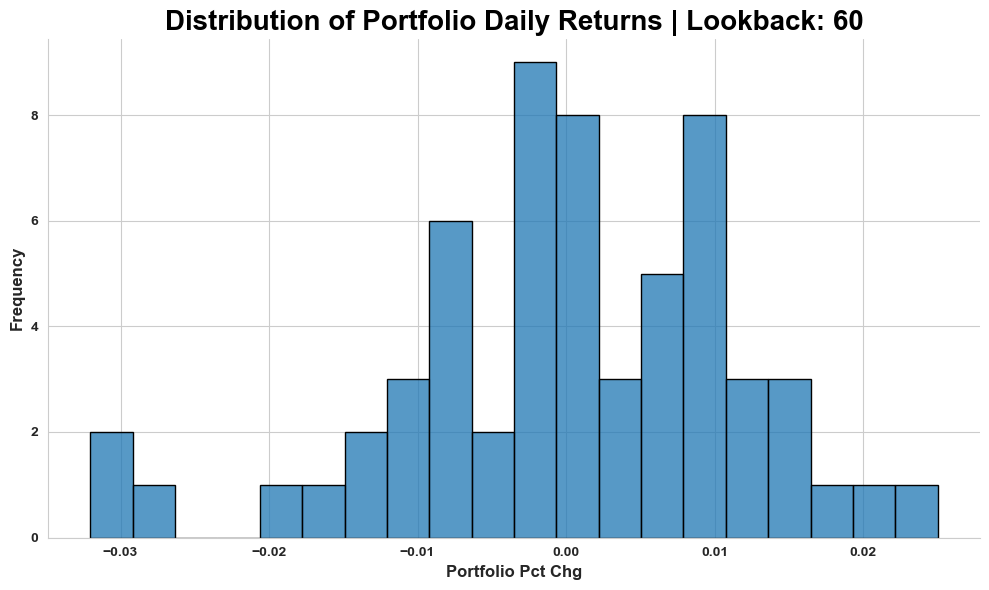

In [85]:
# Visualizing the Portfolio's Return Distribution

VaR.histogram(VaR_portfolio_returns)

In [86]:
# Calculating the Test for Normality

VaR.shapiro_wilks(VaR_portfolio_returns)

'Test for normality p-value of 0.1255 for 60 day lookback'

In [87]:
# Calculating the Chi-Square Test for Goodness of Fit

VaR.chi_square_test(VaR_portfolio_returns)

'Goodness of fit p-value of 0.0305 for 60 day lookback'

In [88]:
# Calculating the Portfolio's VaR Using a Parametric Method

VaR.parametric_normal(VaR_portfolio_returns)

'-1057.37 VaR for 60 day lookback'

In [89]:
# Calculating the Portfolio's VaR Using a Historical Percentile Method

VaR.historic_percentile(VaR_portfolio_returns)

'-1065.71 VaR for 60 day lookback'

### Graphing VaR for Each Lookback Period

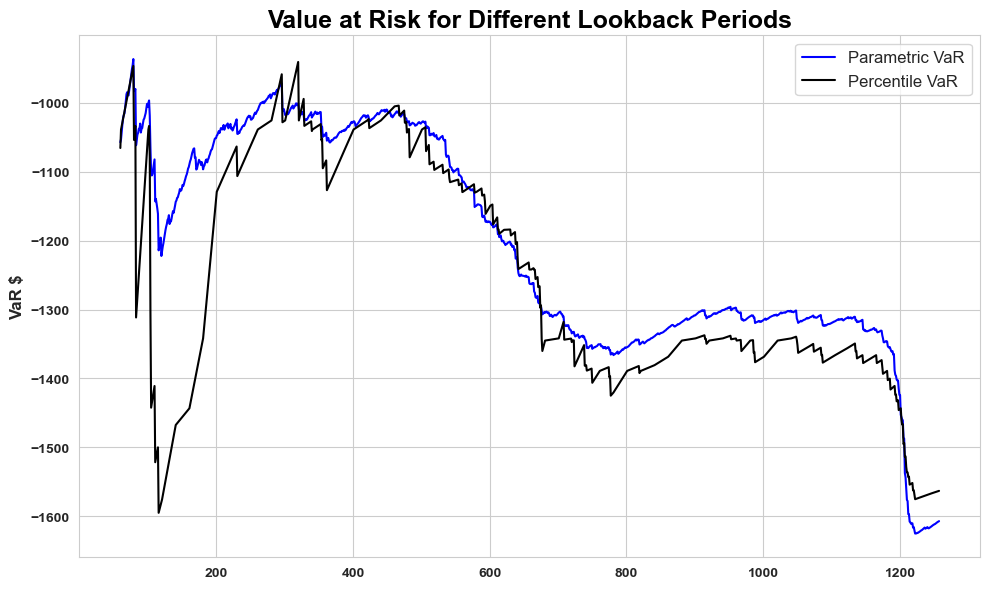

In [90]:
# Iterating Over a Lookback for Range to Calculate and Plot VaR

pf_VaR_para_ls = []
pf_VaR_hist_ls = []
lookback_range = np.arange(60, len(yf_px_df))

for lookback in lookback_range:
    VaR = ValueAtRisk(px_hist=yf_px_df, hlds=hlds_dict, percentile=5, alpha=0.05, lookback=lookback, bins=20)
    
    VaR_portfolio_returns = VaR.portfolio_returns()
    
    pf_VaR_para = VaR.parametric_normal(VaR_portfolio_returns)
    pos1 = pf_VaR_para.find(" ")
    pf_VaR_para = pf_VaR_para[:pos1]
    pf_VaR_para_ls.append(float(pf_VaR_para))

    pf_VaR_hist = VaR.historic_percentile(VaR_portfolio_returns)
    pos2 = pf_VaR_hist.find(" ")
    pf_VaR_hist = pf_VaR_hist[:pos2]
    pf_VaR_hist_ls.append(float(pf_VaR_hist))


plt.figure(figsize=(10, 6))

plt.plot(lookback_range, pf_VaR_para_ls, label='Parametric VaR', color='blue', linestyle='-')
plt.plot(lookback_range, pf_VaR_hist_ls, label='Percentile VaR', color='black', linestyle='-')

plt.legend(fontsize=12)

plt.title(f"Value at Risk for Different Lookback Periods", fontsize=18, fontweight='bold', color='black')
plt.ylabel("VaR $", fontsize=12, fontweight='bold')
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()